<a href="https://colab.research.google.com/github/vicaaa12/introduction-to-Computer-Vision/blob/main/Plant_Seedling_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import math
import cv2
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Display images using OpenCV
from google.colab.patches import cv2_imshow
from tensorflow.keras import backend

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [2]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/project/images(2) (1).npy')
#Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/project/Labels(2).csv')

## Data Overview

### Understand the shape of the dataset

In [4]:
#Print shape of the images and labels
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB images of shape 128 x 128 x 3, each image having 3 channels

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [5]:
def plot_images(images,labels):
  num_classes=10
  categories=np.unique(labels)
  keys=dict(labels['Label'])
  rows = 3
  cols = 4
  fig = plt.figure(figsize=(10,8))
  for i in range(cols):
    for j in range(rows):
      random_index = np.random.randint(0, len(labels))
      ax = fig.add_subplot(rows, cols, i * rows + j + 1)
      ax.imshow(images[random_index, :])
      ax.set_title(keys[random_index])
  plt.show()

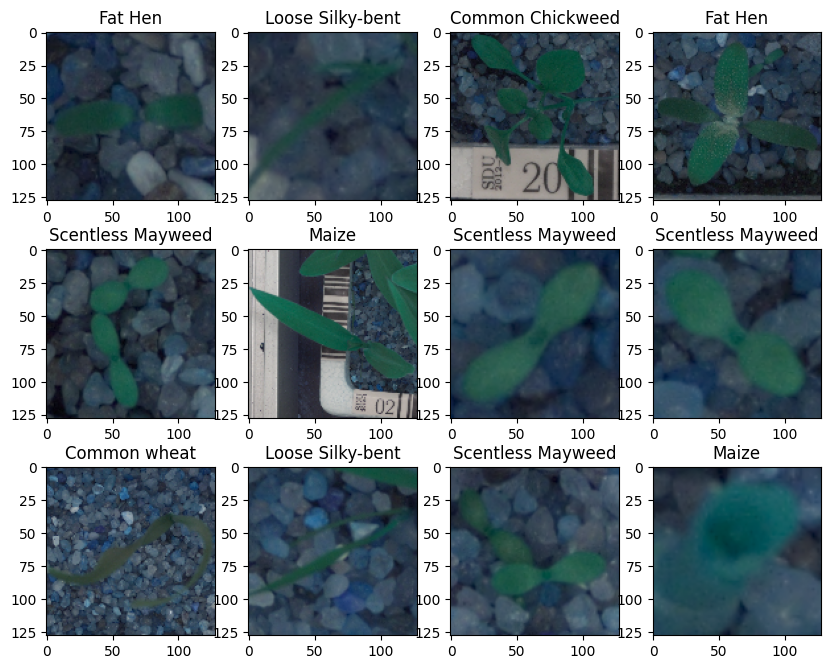

In [6]:
plot_images(images, labels)

Checking for data imbalance

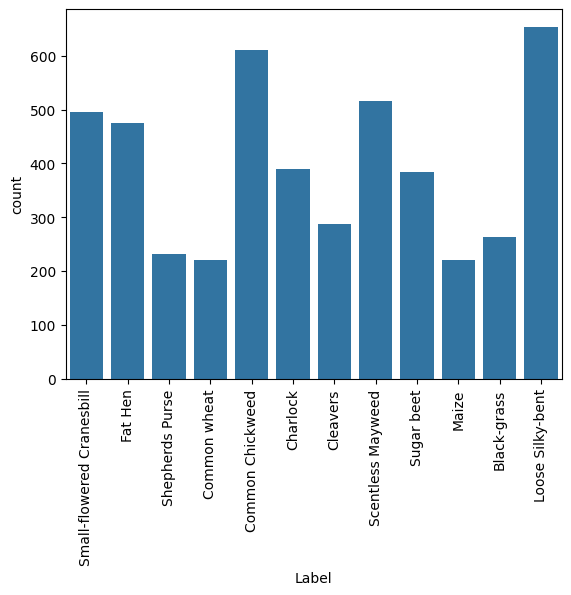

In [7]:
# Ensure 'Label' is a string or categorical column
labels['Label'] = labels['Label'].astype(str)

# Use value_counts to create a countplot
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

# Show the plot
plt.show()

* As you can see from the above plot, the dataset is imbalanced.
* "Loose Silky bent" plant samples are more compared to other categories
    Least plant samples are for "Common Wheat", "Maize", "Shepherds Purse"


## Data Pre-Processing

### Convert the BGR images to RGB images.

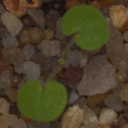

In [8]:
cv2_imshow(images[5])

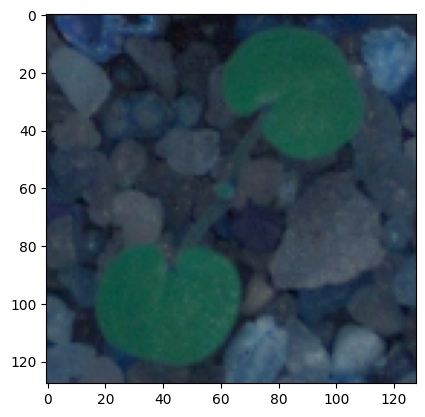

In [9]:
plt.imshow(images[5])

We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV. Now we will convert these BGR images to RGB images so we could interpret them easily

In [10]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [11]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

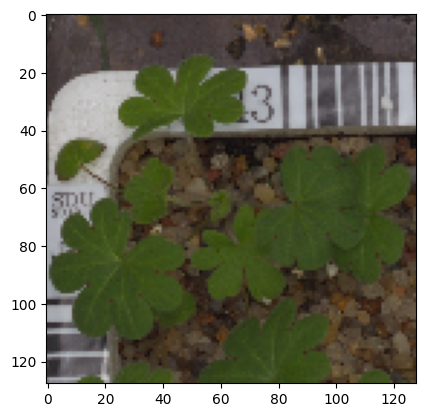

In [12]:
plt.imshow(images[3])

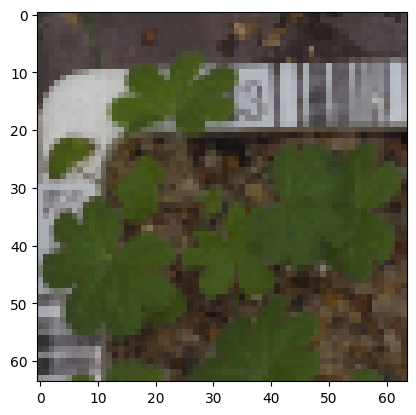

In [13]:
plt.imshow(images_decreased[3])

In [14]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3), sigmaX = 0))

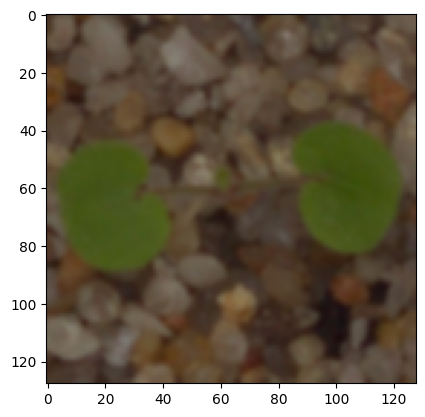

In [15]:
plt.imshow(images_gb[0])

* It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [16]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_gb), labels, test_size=0.1, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42, stratify=y_temp)

In [17]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3847, 128, 128, 3) (3847, 1)
(428, 128, 128, 3) (428, 1)
(475, 128, 128, 3) (475, 1)


### Encode the target labels

In [18]:
# Convert labels from names to one hot vectors
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [19]:
unique_classes = enc.classes_
print(len(unique_classes))

12


There are 12 unique classes

### Data Normalization

In [20]:
# Normalizing the image pixels

X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [21]:
X_train_normalized.shape

(3847, 128, 128, 3)

## Model Building

In [22]:
# Clearing backend
backend.clear_session()

In [23]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [24]:
# Intializing a sequentisl model
model1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 5 x 5, padding 'same' provides the output size same as the input size

model1.add(Conv2D(64, (5,5), activation='relu', padding='same', input_shape=(128,128,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization())
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization())
model1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(BatchNormalization())
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))


# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
model1.add(Dense(12, activation='softmax'))

opt=Adam()
# Compile model
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 128)       0         
 g2D)                                                            
                                                        

In [25]:
history_1 = model1.fit(X_train_normalized, y_train_encoded,
                      epochs=30,
                      validation_data=(X_val_normalized, y_val_encoded),
                      batch_size=32,
                      verbose=2)

Epoch 1/30
121/121 - 12s - loss: 1.9218 - accuracy: 0.4073 - val_loss: 6.9838 - val_accuracy: 0.0864 - 12s/epoch - 98ms/step
Epoch 2/30
121/121 - 4s - loss: 1.2716 - accuracy: 0.5831 - val_loss: 9.4302 - val_accuracy: 0.1192 - 4s/epoch - 36ms/step
Epoch 3/30
121/121 - 4s - loss: 0.9749 - accuracy: 0.6735 - val_loss: 9.7453 - val_accuracy: 0.1519 - 4s/epoch - 33ms/step
Epoch 4/30
121/121 - 4s - loss: 0.7445 - accuracy: 0.7343 - val_loss: 6.2154 - val_accuracy: 0.2079 - 4s/epoch - 33ms/step
Epoch 5/30
121/121 - 4s - loss: 0.6623 - accuracy: 0.7663 - val_loss: 3.7959 - val_accuracy: 0.3785 - 4s/epoch - 33ms/step
Epoch 6/30
121/121 - 4s - loss: 0.5204 - accuracy: 0.8152 - val_loss: 1.7086 - val_accuracy: 0.6145 - 4s/epoch - 32ms/step
Epoch 7/30
121/121 - 4s - loss: 0.4182 - accuracy: 0.8539 - val_loss: 1.3361 - val_accuracy: 0.6565 - 4s/epoch - 32ms/step
Epoch 8/30
121/121 - 4s - loss: 0.3381 - accuracy: 0.8804 - val_loss: 4.3796 - val_accuracy: 0.4393 - 4s/epoch - 34ms/step
Epoch 9/30
121

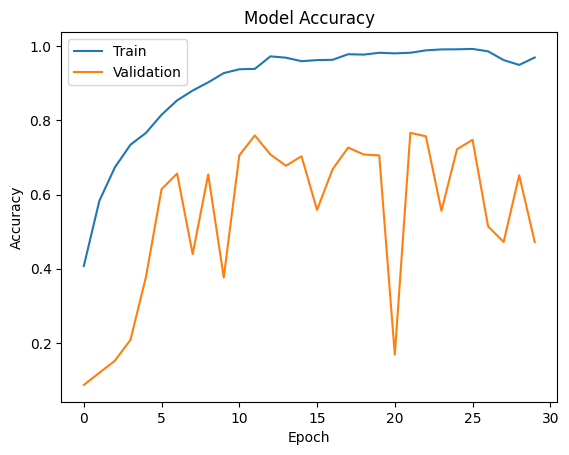

In [26]:
#Model evaluation

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 1s - loss: 4.5177 - accuracy: 0.4463 - 651ms/epoch - 43ms/step


**Observations:**

* The accuracy is very low
* The model is overfitting
* To address this issue, I will implement several techniques, including data augmentation, Batch Normalization, and Dropout. These methods are known to be effective in mitigating overfitting and improving model performance

## Model Performance Improvement

**Reducing the Learning Rate:**

**ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [28]:
# Clearing backend

backend.clear_session()

In [29]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(

                              rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True,
                              fill_mode='nearest'
                              )
# test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [30]:
# Intializing a sequentisl model #2
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3 x 3, padding 'same' provides the output size same as the input size

model2.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(128,128,3)))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())
model2.add(Dense(128, use_bias=False))
model2.add(BatchNormalization())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16, activation='relu'))

# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(12, activation='softmax'))

opt=Adam()
# Compile model
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 128)       0         
 g2D)                                                            
                                                        

In [31]:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, mode='auto')

In [32]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00001)

In [33]:
epochs = 70
# Batch size
batch_size = 64

history_2 = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),
                                       epochs=epochs,
                                       steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                                       validation_data=(X_val_normalized,y_val_encoded),
                                       verbose=1,callbacks=[learning_rate_reduction])

Epoch 1/70
60/60 [==============================] - 26s 324ms/step - loss: 1.9736 - accuracy: 0.3643 - val_loss: 3.3096 - val_accuracy: 0.1005 - lr: 0.0010
Epoch 2/70
60/60 [==============================] - 18s 297ms/step - loss: 1.3343 - accuracy: 0.5784 - val_loss: 4.7550 - val_accuracy: 0.1308 - lr: 0.0010
Epoch 3/70
60/60 [==============================] - 17s 285ms/step - loss: 1.0428 - accuracy: 0.6590 - val_loss: 6.3153 - val_accuracy: 0.1379 - lr: 0.0010
Epoch 4/70
60/60 [==============================] - 17s 295ms/step - loss: 0.8604 - accuracy: 0.7142 - val_loss: 5.9868 - val_accuracy: 0.1659 - lr: 0.0010
Epoch 5/70
60/60 [==============================] - 18s 290ms/step - loss: 0.7553 - accuracy: 0.7473 - val_loss: 7.1569 - val_accuracy: 0.1402 - lr: 0.0010
Epoch 6/70
60/60 [==============================] - 17s 287ms/step - loss: 0.6502 - accuracy: 0.7801 - val_loss: 8.2830 - val_accuracy: 0.1449 - lr: 0.0010
Epoch 7/70
60/60 [==============================] - ETA: 0s - lo

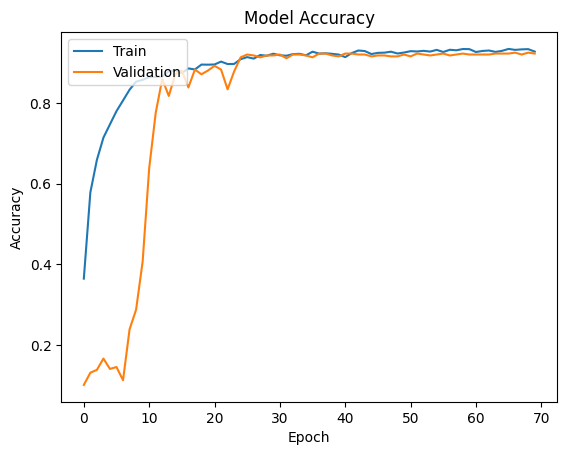

In [34]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 0.2926 - accuracy: 0.9011 - 304ms/epoch - 20ms/step


In [36]:
# Here we would get the output as probablities for each category
y_pred=model2.predict(X_test_normalized)

15/15 [==============================] - 0s 9ms/step


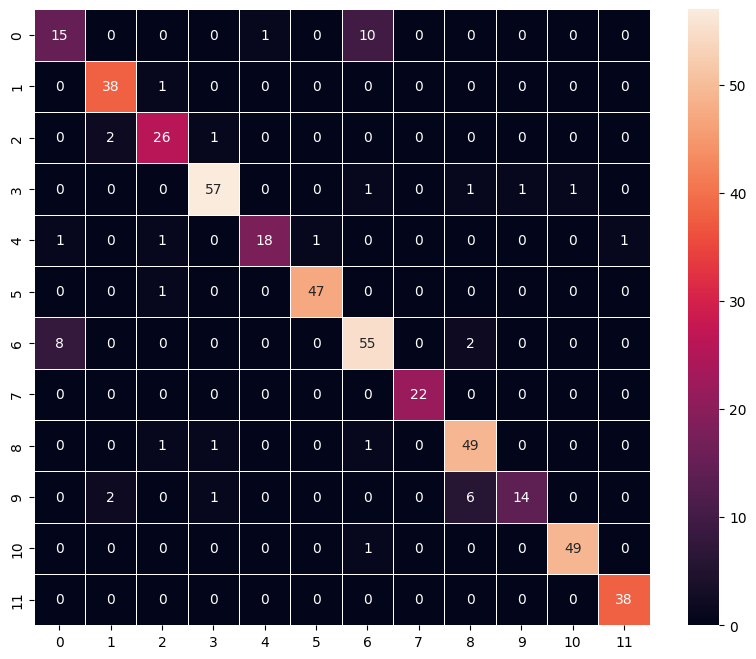

In [37]:
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

In [38]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.62      0.58      0.60        26
           1       0.90      0.97      0.94        39
           2       0.87      0.90      0.88        29
           3       0.95      0.93      0.94        61
           4       0.95      0.82      0.88        22
           5       0.98      0.98      0.98        48
           6       0.81      0.85      0.83        65
           7       1.00      1.00      1.00        22
           8       0.84      0.94      0.89        52
           9       0.93      0.61      0.74        23
          10       0.98      0.98      0.98        50
          11       0.97      1.00      0.99        38

    accuracy                           0.90       475
   macro avg       0.90      0.88      0.89       475
weighted avg       0.90      0.90      0.90       475



We can observe that our accuracy has improved compared to our previous model.

In [39]:
backend.clear_session()

In [40]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (128,128,3))
vgg_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [41]:
# Making all the layers exluding thye last 4 of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [42]:
model3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model3.add(Flatten())

# Adding a dense output layer
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(16, activation='relu'))
model3.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 14977596 (57.13 MB)
Trainable params: 2629

In [43]:
# Epochs
epochs =80
# Batch size
batch_size = 64

history_vgg16 = model3.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1, callbacks=[learning_rate_reduction])

Epoch 1/80
60/60 [==============================] - 30s 387ms/step - loss: 2.3821 - accuracy: 0.1594 - val_loss: 2.2276 - val_accuracy: 0.2336 - lr: 0.0010
Epoch 2/80
60/60 [==============================] - 17s 287ms/step - loss: 2.1840 - accuracy: 0.2440 - val_loss: 2.0450 - val_accuracy: 0.2850 - lr: 0.0010
Epoch 3/80
60/60 [==============================] - 18s 296ms/step - loss: 2.0258 - accuracy: 0.2889 - val_loss: 1.9136 - val_accuracy: 0.3528 - lr: 0.0010
Epoch 4/80
60/60 [==============================] - 18s 292ms/step - loss: 1.9166 - accuracy: 0.3267 - val_loss: 1.8130 - val_accuracy: 0.4065 - lr: 0.0010
Epoch 5/80
60/60 [==============================] - 17s 289ms/step - loss: 1.8108 - accuracy: 0.3513 - val_loss: 1.6655 - val_accuracy: 0.4276 - lr: 0.0010
Epoch 6/80
60/60 [==============================] - 19s 315ms/step - loss: 1.7457 - accuracy: 0.3669 - val_loss: 1.6994 - val_accuracy: 0.4299 - lr: 0.0010
Epoch 7/80
60/60 [==============================] - 17s 288ms/st

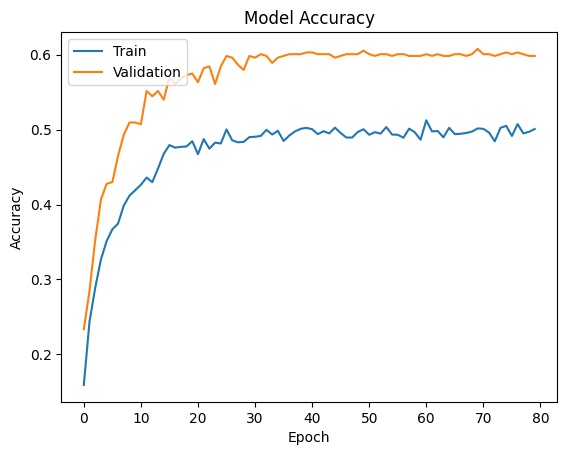

In [44]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 3s - loss: 1.2682 - accuracy: 0.5663 - 3s/epoch - 215ms/step


In [46]:
y_pred=model3.predict(X_test_normalized)

15/15 [==============================] - 1s 45ms/step


In [47]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

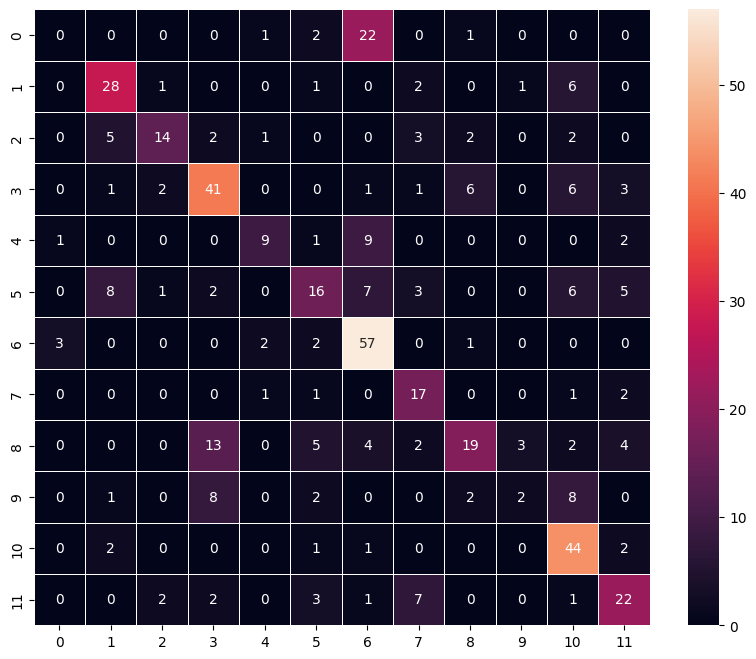

In [48]:
# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()


In [49]:
# Plotting the classification report
cr=metrics.classification_report(y_test_arg,y_pred_arg)     # Complete the code to plot the classification report
print(cr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.62      0.72      0.67        39
           2       0.70      0.48      0.57        29
           3       0.60      0.67      0.64        61
           4       0.64      0.41      0.50        22
           5       0.47      0.33      0.39        48
           6       0.56      0.88      0.68        65
           7       0.49      0.77      0.60        22
           8       0.61      0.37      0.46        52
           9       0.33      0.09      0.14        23
          10       0.58      0.88      0.70        50
          11       0.55      0.58      0.56        38

    accuracy                           0.57       475
   macro avg       0.51      0.51      0.49       475
weighted avg       0.54      0.57      0.53       475



In [50]:
model3.save('./model3.h5')                     # save classifier (model) and architecture to single file
model3.save_weights('./model3_weights.h5')

In [51]:
!ls

drive  model3.h5  model3_weights.h5  sample_data


## Final Model

In [52]:
history = pd.DataFrame(history_2.history)

We can observe from the confusion matrix of all the models that our model 2 is the best model.

### Visualizing the prediction

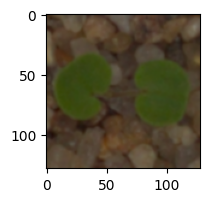

1/1 [==============================] - 0s 215ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


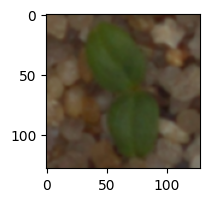

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Cleavers']
True Label Cleavers


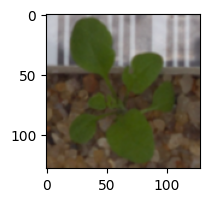

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


In [53]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1,128,128,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[33].reshape(1,128,128,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[36].reshape(1,128,128,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])

## Actionable Insights and Business Recommendations

 * I have developped three  CNN-model to predict the class of a plant.
 * Model #2 shows the best model performance and accurance results.
It was trained on the original image_size  (128 x 128), with preprocessing that included blurring the background. Further improvements can be achieved by experimenting with different filter sizes, adding additional layers, and adjusting the number of filters.
 * I explored a pre-trained VGG model, however, it did not outperform Model #2.  
 * Data augmentation techniques were implemented during training to increase the size of the training set, leading to improved model performance. Model #2 outperforms Model #1.
 * Notably, there is an imbalance in the data. Techniques such as oversampling, undersampling, or using class weights regularization during training can further enhance model performance and ensure that the model is not biased towards the majority class.

Business Recommendation:
Considering the superior performance of Model #2, it is advisable to focus resources and efforts on refining and optimizing this model. Further exploration of techniques such as fine-tuning and additional experimentation with architectural adjustments could contribute to even better results. Additionally, addressing the data imbalance is crucial for ensuring the model's effectiveness across various classes and improving its overall reliability in real-world scenarios.

In [54]:
!jupyter nbconvert --to html "/content/drive/MyDrive/project/High_Code_Plant_Seedling_Classification.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/project/High_Code_Plant_Seedling_Classification.ipynb to html
[NbConvertApp] Writing 2356291 bytes to /content/drive/MyDrive/project/High_Code_Plant_Seedling_Classification.html


_____